<a href="https://colab.research.google.com/github/skywalker0803r/ESun2021WinterGame/blob/main/Proof_of_Concept/%E5%88%A9%E7%94%A8apply%E5%8F%96%E4%BB%A3for%E8%BF%B4%E5%9C%88%E4%BE%86%E5%8A%A0%E9%80%9F%E9%81%8B%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
tqdm.pandas()

size = 10000
df = pd.DataFrame()
df['dt'] = np.random.randint(0,25,size=size)
df['chid'] = np.random.randint(10000,10000+500,size=size)
df['shop_tag'] = np.random.randint(0,5,size=size)
df = df.sort_values(by='dt')
df

C:\Users\ricky\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,dt,chid,shop_tag
3998,0,10224,0
288,0,10364,3
2939,0,10492,1
5904,0,10109,2
1217,0,10042,3
...,...,...,...
240,24,10185,1
8701,24,10410,4
6785,24,10403,4
9262,24,10401,3


In [2]:
chid = df.loc[1,'chid']
dt = df.loc[1,'dt']
cond = (df.dt>=dt)&(df.chid==chid)
df.loc[cond]

,dt,chid,shop_tag
1,6,10123,1
6190,7,10123,0
7003,7,10123,0
8457,9,10123,1
7881,9,10123,1
8340,10,10123,1
4061,10,10123,4
5180,11,10123,1
991,12,10123,1
8530,12,10123,2


In [3]:
df.loc[cond,'shop_tag'].value_counts()

1    8
0    5
4    4
2    2
3    1
Name: shop_tag, dtype: int64

In [4]:
s = time.time()
answer_list = []
for idx in tqdm(df.index):
  cond = (df.dt>=14)&(df.chid==df.loc[idx,'chid'])
  answer = df.loc[cond,'shop_tag'].value_counts()[:3].index.tolist()
  if len(answer) == 3:
    answer_list.append(answer)
  else:
    remain = 3-len(answer)
    for _ in range(remain):
      answer.append(np.random.choice([0,1,2,3,4]))
    assert len(answer) == 3
    answer_list.append(answer)
answer_list = np.array(answer_list)
df['top1'] = answer_list[:,0]
df['top2'] = answer_list[:,1]
df['top3'] = answer_list[:,2]
df
for_cost_t = time.time() - s

100%|██████████| 10000/10000 [00:09<00:00, 1021.15it/s]


In [5]:
print(for_cost_t)
df

9.81277871131897


,dt,chid,shop_tag,top1,top2,top3
3998,0,10224,0,3,0,2
288,0,10364,3,0,1,4
2939,0,10492,1,3,1,0
5904,0,10109,2,2,1,0
1217,0,10042,3,3,4,1
...,...,...,...,...,...,...
240,24,10185,1,3,2,1
8701,24,10410,4,4,3,2
6785,24,10403,4,4,3,0
9262,24,10401,3,3,0,0


In [7]:
s = time.time()
def f(chid):
  cond = (df.dt>=14)&(df.chid==chid)
  answer = df.loc[cond,'shop_tag'].value_counts()[:3].index.tolist()
  if len(answer) == 3:
    return answer
  else:
    remain = 3-len(answer)
    for _ in range(remain):
      answer.append(np.random.choice([0,1,2,3,4]))
    assert len(answer) == 3
    return answer
answer_list = df['chid'].progress_apply(f)
answer_list = answer_list.to_frame()['chid']
df['top1'] = answer_list.apply(lambda x:x[0]).values
df['top2'] = answer_list.apply(lambda x:x[1]).values
df['top3'] = answer_list.apply(lambda x:x[2]).values
df
apply_cost_t = time.time() - s

100%|██████████| 10000/10000 [00:08<00:00, 1133.68it/s]


In [8]:
print(apply_cost_t)
df

8.834151029586792


,dt,chid,shop_tag,top1,top2,top3
3998,0,10224,0,3,0,2
288,0,10364,3,0,1,4
2939,0,10492,1,3,1,0
5904,0,10109,2,2,1,0
1217,0,10042,3,3,4,1
...,...,...,...,...,...,...
240,24,10185,1,3,2,1
8701,24,10410,4,4,3,2
6785,24,10403,4,4,3,0
9262,24,10401,3,3,0,3


<BarContainer object of 2 artists>

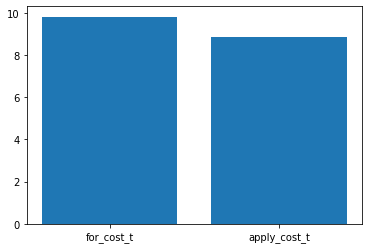

In [9]:
plt.bar(x=['for_cost_t','apply_cost_t'],height=[for_cost_t,apply_cost_t])